# Preliminary sizing of a rotor blade

As previously mentioned we will use the work of Adkins and Liebeck to perform both optimisation and off design analysis. Let us start with the rotor blade optimisation.

The method has been implemented in Python in the package called `tuduam`, i.e TU Delft Urban Air Mobility. Hence, when creating the input we have to keep in mind the [documentation]() (<span style="color: red;"> TODO: insert missing link) </span> on what the functions expect. Feel free to roam around the documentatin to see what other functionalities are offered by the package. Keep in mind however that the package is under active development.

The design is initiated with the specified conditions of power (or thrust), hub and tip radius, rotational rate, freestream velocity, number of blades, and a finite number of stations at which blade geometry is to be determined. Let us define this in the next block

## Defining the conditions

Most of the code below does not need explaining, however as previusly mentioned we must take into account the [API documentation]() (<span style="color: red;"> TODO: insert missing link).</span> Here it says that the blade parameter must be defined in the `Propeller` data structure. Furthermore, BEM analysis requires airfoil polar at a large range of reynolds numbers. `tuduam` relies on the user to input this data in the form of a path to a directory which contains all the polars. These files should be in the common format outputted by [xfoil](https://web.mit.edu/drela/Public/web/xfoil/). A tutorial on how to create this data has also been made [here]()(<span style="color: red;"> TODO: insert missing link to data creation notebook). </span>. Sample data for the NACA 4412, a common propeller, is readily available however in the `tuduam` repository. The NACA 4412 is shown in [Figure 1](#figure1)

<br>
<p align="center"  id="figure1" style="background-color: white;">
<img src="https://raw.githubusercontent.com/saullocastro/tuduam/076078cd60feddd2ee2d784fcd93ccbed26041c6/notebooks/static/naca4412-il.svg" width="400" /> 
 <br>
</p>
<p align="center">
<em>Figure 1: The NACA 4412 airfoil</em>
</p>
<br>

The conditions required for the optimisation are loaded into the Python kernel below. Carefully read the comments surrounding the code for more pointers.

In [3]:
import sys
import os
sys.path.insert(0, os.path.dirname(os.path.abspath('')))

import tuduam as tud
import tuduam.propulsion as prop

# Define parameters required by API
data_path = os.path.realpath(os.path.join(os.path.abspath('.'), '..', 'examples', 'data')) # Path to airfoil data
coord_path = os.path.realpath(os.path.join(os.path.abspath('.'), '..', 'examples', 'naca_4412.txt')) # Path to airfoil coordinates
n_stations = 25

# Define operatonal parameters
thrust_req = 400
v_cruise = 210/3.6
h_cruise = 1200
isa = tud.ISA(h_cruise) 
a_snd = isa.soundspeed()
rho_cr = isa.density()
dyn_vis = isa.viscosity_dyn()

# Define the specified conditions for the propeller geometry in the data structure
prop_class = tud.Propeller(
                    n_blades=6, # Number of blades
                    r_prop=0.6, # propeller radius
                    rpm_cruise=1200, 
                    tc_ratio=0.12,  # Thickness to chord ratio of airfoil
                    xi_0=0.1 # nondimensional hub radius (r_hub/R)
                    ) 

# Running the optimisation

Having defined the conditions we now run the actual optimisation. In the code it will be as simple as calling a single line however there is much going on in the background. A general overview of procedure is described here however for a full description refer to the paper (download link available in the course in sources). 

The general procedure can be condensed to the following:

1. Select an initial estimate for $\zeta$, the displacement velocity ratio ($\zeta$ = 0 will work).
2. Determine the values for $F$, the Prandtl momentum loss factor, and $\phi$, the flow angle, at each blade station.
3. Determine the product $Wc$, the local velocity multiplied by the local chord. Additionally, compute the Reynolds number.
4. Determine $\epsilon$, the drag-to-lift ratio, and $\alpha$, the angle of attack, from airfoil section data.
5. If $\epsilon$ is to be minimized, change $C_l$, and repeat Steps 3 and 4 until this is accomplished at each station.
6. Determine $\alpha$ and $\alpha'$, the axial and rotational interference factor, respectively.
7. Compute the chord from Step 3, and the blade twist $\beta = \alpha + \phi$.
8. Determine the four derivatives in I and J, and numerically integrate these from the non-dimensional hub radius, $\xi_0$ to the non-dimensional radius $\xi$ = 1.
9. Determine $\zeta$ and $T_c$, the thrust coefficient.
10. If this new value for $\zeta$ is not sufficiently close to the old one (e.g., within 0.1\%), start over at step 2 using the new $\zeta$.
11. Determine propeller efficiency as $\eta = \frac{T}{P_c}$, and other features such as solidity.

Let us now run and plot the resulting blade geometry. Before doing so 

The available keys in the res_dict dictionary are as followed:

chord_arr
pitch_arr
alpha_arr
station_arr
drag_to_lift_arr
v_e
solidity
cl
cd
eff
tc
pc
zeta

The available results can be accessed like so res_dict['eff']=0.8454733980821967


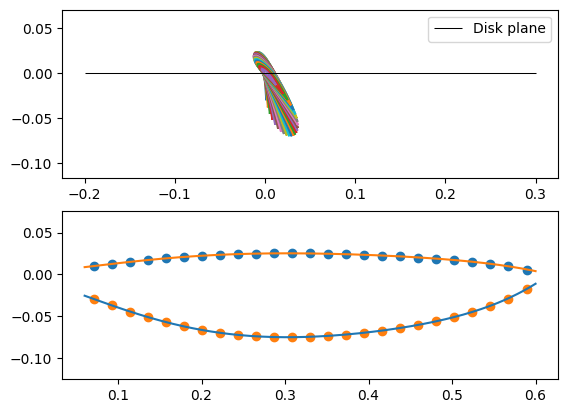

In [4]:
# Initiazlie BEM class
design = prop.BEM(data_path, prop_class, rho_cr, 
                  dyn_vis, v_cruise, n_stations, a_snd, T=thrust_req)

# Execute the BEM optimisation with initial estimate of 0
res_dict = design.optimise_blade(zeta_init=0)

# Print the available results to the user
print(f"The available keys in the res_dict dictionary are as followed:\n")
[print(i) for i in res_dict.keys()]
print(f"\nThe available results can be accessed like so {res_dict['eff']=}")

# Plot the results
plot = prop.PlotBlade(prop_class, coord_path)
plot.plot_blade()
plot.plot_3D_plotly()